In [1]:
import numpy as np
from scipy.io import loadmat
from scipy.optimize import linear_sum_assignment
import cv2

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics.cluster import contingency_matrix

import matplotlib as mpl
import matplotlib.pyplot as plt

from SegClust import *

Create SegClust object

In [2]:
worker = SegClust()

Load test image

In [3]:
fullname = './119082.jpg'
img_clon = cv2.imread(fullname)
img = cv2.cvtColor(img_clon, cv2.COLOR_BGR2YCR_CB)
goldst = loadmat('./119082.mat')

In [4]:
# error tolerance
eps_tol = 10e-15
# size limit is used to reduce image size
size_limit = 200
# no. of iteration for setup method
model_iter = 20
# radius for Birch and DBSCAN
sampling_rad = 5
# min_samples used for DBSCAN
min_samples_reduce = 1
# no. of neighbours used for Knn Classifiers in fit_predict. For reconstruction.
min_samples = 10
# PCA parameters. No sklearn.PCA applied
no_pca = True
whiten = True
# sp and sr are parameters from cv2.pyrMeanShiftFiltering
# any of the two in 0 means no cv2.pyrMeanShiftFiltering
sp=0
sr=20
# cv2.blur kernel windows
blur_size=5

Set Object parameters and find colormodel for clustering

In [5]:
worker.set(sp=sp, sr=sr, blur_size=blur_size, sampling_rad=sampling_rad, min_samples_reduce=min_samples_reduce, 
           min_samples=min_samples, size_limit=size_limit, no_pca=no_pca, whiten=whiten, mode='clust')
colormodel = worker.ColorModel(img, correct_model=True, model_iter=5, heatpoints=1)

We use GMM, Kmeans and HC-av to cluster the colormodel

In [6]:
ks = np.arange(2, 12, dtype = np.int32)
gmm_L = np.hstack([GaussianMixture(n_components=k).fit_predict(colormodel)[:, np.newaxis] for k in ks])
km_L = np.hstack([KMeans(n_clusters=k).fit_predict(colormodel)[:, np.newaxis] for k in ks])
hc_L = np.hstack([AgglomerativeClustering(n_clusters=k, linkage='average').fit_predict(colormodel)[:, np.newaxis] for k in ks])

We contrast the clustering labels against Human Segmentations. 119082.jpg is a BSD500 image and 119082.mat is the human segmentation.

In [7]:
acc_km = []
acc_hc = []
acc_gmm = []
for k in ks:
    L_gmm = worker.fit_predict(gmm_L[:, k-2])
    L_km = worker.fit_predict(km_L[:, k-2])
    L_hc = worker.fit_predict(hc_L[:, k-2])
    acc_l_gmm = []
    acc_l_km = []
    acc_l_hc = []
    for idx_gt in np.arange(0, goldst['groundTruth'].shape[1]):
        cost = -contingency_matrix(goldst['groundTruth'][0, idx_gt][0][0][0], L_gmm)
        row_ind, col_ind = linear_sum_assignment(cost)
        acc_l_gmm.append(-cost[row_ind, col_ind].sum()/np.float64(worker.im_color_seg.size))

        cost = -contingency_matrix(goldst['groundTruth'][0, idx_gt][0][0][0], L_km)
        row_ind, col_ind = linear_sum_assignment(cost)
        acc_l_km.append(-cost[row_ind, col_ind].sum()/np.float64(worker.im_color_seg.size))

        cost = -contingency_matrix(goldst['groundTruth'][0, idx_gt][0][0][0], L_hc)
        row_ind, col_ind = linear_sum_assignment(cost)
        acc_l_hc.append(-cost[row_ind, col_ind].sum()/np.float64(worker.im_color_seg.size))

    acc_gmm.append(np.array(acc_l_gmm).mean())
    acc_km.append(np.array(acc_l_km).mean())
    acc_hc.append(np.array(acc_l_hc).mean())
acc_gmm = np.array(acc_gmm)
acc_km = np.array(acc_km)
acc_hc = np.array(acc_hc)

Accuracy plot for GMM, Kmeans and HC-av.

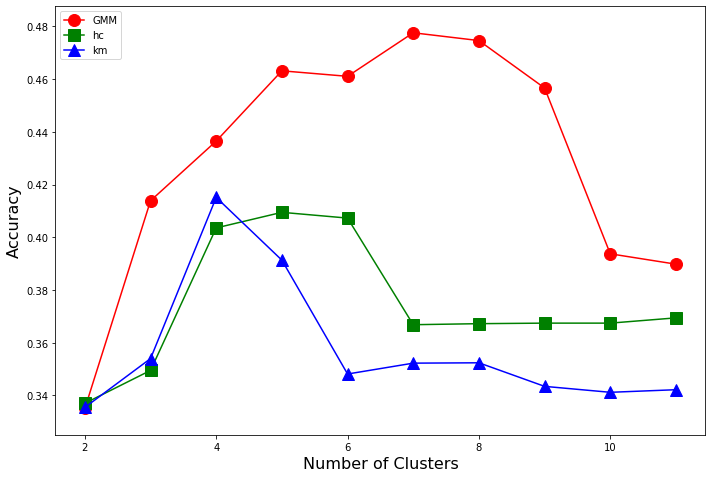

In [8]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10.5, 7))
fig.subplots_adjust(left=0.11, right=0.97, top=0.97, bottom=0.12)
ax.plot(ks, acc_gmm,  marker='o', markersize=12, c='red', label='GMM')
ax.plot(ks, acc_hc,  marker='s', markersize=12, c='green', label='hc')
ax.plot(ks, acc_km,  marker='^', markersize=12, c='blue', label='km')

acc = np.stack((acc_gmm, acc_km, acc_hc))
ax.set_ylim([acc.min()-0.01, acc.max()+0.01])
del acc
ax.set_xlabel('Number of Clusters', fontsize=16)
ax.set_ylabel('Accuracy', fontsize=16)
l = plt.legend(loc="upper left")

We use the clustering labels to predict the mask for the whole image. We use Knn.

In [9]:
k_gmm = np.argmax(acc_gmm)
k_km = np.argmax(acc_km)
k_hc = np.argmax(acc_hc)
L_gmm = worker.fit_predict(gmm_L[:, k_gmm])
L_km = worker.fit_predict(km_L[:, k_km])
L_gmm = worker.fit_predict(hc_L[:, k_hc])
mask_gmm = worker.colorizelabel(L_gmm)
mask_km = worker.colorizelabel(L_km)
mask_hc = worker.colorizelabel(L_hc)

We show the original image and the GMM, Kmeans and HC-av masks.

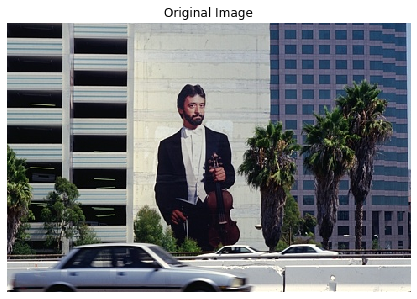

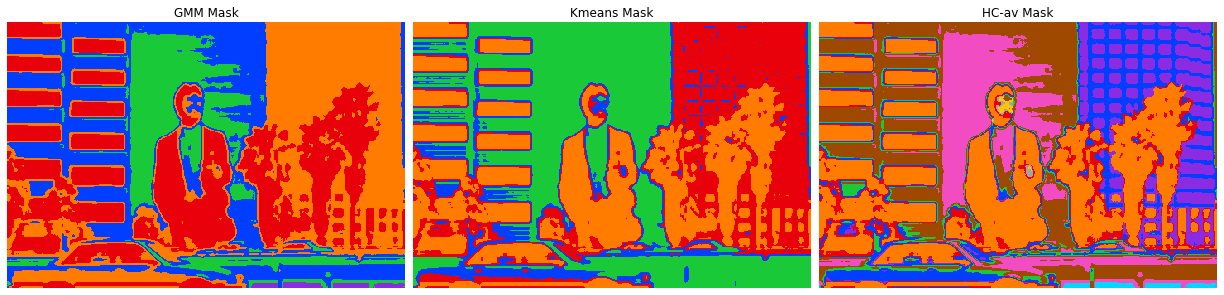

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9, wspace=0.02, hspace=0.02)
l = ax.imshow(cv2.cvtColor(img_clon, cv2.COLOR_BGR2RGB))
l = ax.axis('off')
l = ax.set_title('Original Image')

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(21, 7))
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9, wspace=0.02, hspace=0.02)

ax[0].imshow(mask_gmm)
ax[0].axis('off')
l = ax[0].set_title('GMM Mask')

ax[1].imshow(mask_km)
ax[1].axis('off')
l = ax[1].set_title('Kmeans Mask')

ax[2].imshow(mask_hc)
ax[2].axis('off')
l = ax[2].set_title('HC-av Mask')